**Version: 1.0.1**

If you encounter any errors, please contact me. I will complete the verification and make corrections as soon as possible.

# Usage Guide

This code consists of three sections: AutoML, Interpretability Analysis, and Exploratory Factor Analysis (EFA).
When using this code, please remember to cite this article. 
Each section includes detailed comments, so please modify the respective variables according to the comments to complete your research.

0. **Preoaration**
1. **AutoML**: Utilize AutoML tools for model training and optimization.
2. **Interpretability Analysis**: Use tools like SHAP for model interpretability analysis to identify important features and their relationships.
3. **Exploratory Factor Analysis (EFA)**: Conduct EFA to uncover the underlying factor structure in the data.

Please adjust the respective variables and parameters according to your specific needs to fit your research data and objectives.


# 0 Preparation

In this section, you need to import the necessary libraries for the code to function correctly. Ensure that each library is successfully imported before proceeding with further steps.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from autogluon.tabular import TabularDataset, TabularPredictor
from scipy import stats
import shap
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo, Rotator
from sklearn.decomposition import PCA

## 0.1 Data Import
**Feature Engineering**

In this section, you need to import your data and ensure it is converted into a tabular format, with the first row containing the column names. Modify the file path to the CSV file that contains your data.

In [2]:
# 数据读取，查看数据
# Modify the file path to point to your CSV data file
# Load the data into a pandas DataFrame
file_path = '/Users/sunxinru/Desktop/ML/Data/ML_pre.csv'
data=pd.read_csv(file_path,header=0) 
# Display the first few rows of the data to verify successful import
print(data.head())

   selfclarity_1  selfclarity_2  selfclarity_3  selfclarity_4  selfclarity_5  \
0       0.314527      -0.326269       0.760821      -0.859175       0.492151   
1       0.314527       0.458962      -0.906687      -0.032856       0.492151   
2       1.369240       0.458962       0.760821       1.619782       1.322862   
3       0.314527       1.244192       1.594575       0.793463       1.322862   
4      -0.740186      -1.896730      -0.906687      -1.685493      -1.999982   

   selfclarity_6  selfclarity_7  selfclarity_8  selfclarity_9  selfclarity_10  \
0       0.306556       0.413315       0.345348       0.381702       -0.837878   
1       0.306556       0.413315       0.345348      -0.425004        0.764603   
2       0.306556       0.413315       1.145854       1.188408        0.764603   
3       0.306556       1.283179       0.345348       1.188408        1.565844   
4      -1.683093      -0.456549      -1.255664      -1.231711       -0.837878   

   ...  moral_ALT_rt  ability_AL

## 0.2 Data Selection

In psychological research, not all features are necessarily included in the analysis. 
Therefore, after `data.iloc`, input all the variables you wish to include (including the dependent variable). 
Modify the line `target = data['CD-RISC']` by replacing `CD-RISC` with the name of your dependent variable as it appears in your CSV file.

In [3]:
# Modify with the columns you need
#features = data.iloc[:, 1:44]

# Modify 'CD-RISC' to the name of your dependent variable
#target = data['CD-RISC']

#data = pd.concat([features, target], axis=1)
#for column in data.columns:
    #if pd.api.types.is_numeric_dtype(data[column]):
        #data[column] = data[column].astype('float')

In [3]:
# 取出前 140 列作为特征
features = data.iloc[:, 0:140]   # Python 的列索引是从 0 开始的，所以 0:140 是第1-140列

# 取第 142 gad 列作为目标变量
target = data.iloc[:, 141]

# 合并成新的数据集
data_gad = pd.concat([features, target], axis=1)

# 确保所有数值列转换为 float 类型
for column in data_gad.columns:
    if pd.api.types.is_numeric_dtype(data_gad[column]):
        data_gad[column] = data_gad[column].astype('float')

## 0.3 Handling Anomalies
To facilitate checking for anomalies in the data, count the unique values in each column. 
For example, we can see an anomaly in the "Age" column. There is an erroneous value: `Value: 2.0, Count: 1`, where the age was mistakenly entered as 2.
You can follow this example to modify and handle the anomalies in your data. Adjust the variable name and the range according to your needs.

In [4]:
# 逐列唯一值检查，查看数据里有没有异常值或奇怪的编码
# Count unique values in each column to check for anomalies
for column in data_gad.columns:
    print(f"Column: {column}")
    value_counts = data_gad[column].value_counts(dropna=False)
    for value, count in value_counts.items():
        print(f"Value: {value}, Count: {count}")
    print("\n")

Column: selfclarity_1
Value: 0.314526814129491, Count: 254
Value: 1.36924006417705, Count: 90
Value: -0.740186435918068, Count: 80
Value: -1.79489968596563, Count: 77
Value: -2.84961293601319, Count: 2


Column: selfclarity_2
Value: 0.458961839689885, Count: 166
Value: 1.24419247017972, Count: 116
Value: -1.11149942128979, Count: 107
Value: -0.326268790799952, Count: 73
Value: -1.89673005177963, Count: 41


Column: selfclarity_3
Value: -0.906686528943575, Count: 160
Value: 0.760821054451739, Count: 122
Value: -0.0729327372459181, Count: 110
Value: 1.5945748461494, Count: 76
Value: -1.74044032064123, Count: 35


Column: selfclarity_4
Value: -0.859174549653067, Count: 184
Value: 0.793463303025681, Count: 120
Value: -0.0328556233136928, Count: 91
Value: 1.61978222936506, Count: 75
Value: -1.68549347599244, Count: 33


Column: selfclarity_5
Value: 0.492150779997121, Count: 176
Value: -1.1692709806643, Count: 115
Value: 1.32286166032783, Count: 101
Value: -0.33856010033359, Count: 82
Value:

In [5]:
# 把不符合设定范围的年龄值当作异常值，替换成缺失值 NaN
#To address anomalies, replace values in the "Age" column that are less than 18 or greater than 24 with null values.
#data.loc[(data['Age'] < 18) | (data['Age'] > 24), 'Age'] = np.nan

In [5]:
# 缺失值比例统计
# View Missing Value Proportions
null_ratio = data_gad.isnull().mean()
print(null_ratio)

selfclarity_1      0.0
selfclarity_2      0.0
selfclarity_3      0.0
selfclarity_4      0.0
selfclarity_5      0.0
                  ... 
ability_SRET_EW    0.0
moral_SRET_EW      0.0
ability_SRET_rt    0.0
moral_SRET_rt      0.0
gad                0.0
Length: 141, dtype: float64


In [6]:
# 提供了3种数据补齐的方法：mean，median，mode
# Filling Missing Values with Mean
# data.fillna(data.mean(), inplace=True)
# Filling Missing Values with Median
# data.fillna(data.median(), inplace=True)
# Filling Missing Values with Mode
data.fillna(data_gad.mode().iloc[0], inplace=True)

## 0.4 Data Standardization or Normalization

In this section, you will standardize or normalize the selected columns in your dataset. 
Standardization transforms the data to have a mean of 0 and a standard deviation of 1. 
Normalization scales the data to a range between 0 and 1.

In [8]:
# Extract the columns to be standardized 选取需要操作的列
#columns_to_scale = ['Age'] + list(data.columns[6:43])
# Initialize the StandardScaler 1.对特定的列标准化：把每一列变成 均值 0、标准差 1 的分布，常见于机器学习（尤其是线性模型、SVM、PCA）
#scaler = StandardScaler()
#data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])
# Initialize the MinMaxScaler 2.把数据线性缩放到 [0, 1] 区间，常见于神经网络、基于距离的方法（如 kNN）
# min_max_scaler = MinMaxScaler()
# data[columns_to_scale] = min_max_scaler.fit_transform(data[columns_to_scale])

In [7]:
# 拆分数据
features_1_140 = data_gad.iloc[:, 0:140]      # 前 140 列（已标准化）
features_141_144 = data_gad.iloc[:, 140:144]  # 第 141–144 列（需要标准化）

# 初始化 StandardScaler
scaler = StandardScaler()

# 标准化 141–144 列
features_141_144_scaled = pd.DataFrame(
    scaler.fit_transform(features_141_144),
    columns=features_141_144.columns,  # 保留原始列名
    index=features_141_144.index
)

# 合并：前 140 列 + 标准化后的 141–144 列
data_gad = pd.concat([features_1_140, features_141_144_scaled], axis=1)

# 看前几行检查
display(data_gad.head())

,selfclarity_1,selfclarity_2,selfclarity_3,selfclarity_4,selfclarity_5,selfclarity_6,selfclarity_7,selfclarity_8,selfclarity_9,selfclarity_10,...,Social,Moral,ability_ALT_rt,moral_ALT_rt,ability_ALT_d,ability_SRET_EW,moral_SRET_EW,ability_SRET_rt,moral_SRET_rt,gad
0,0.314527,-0.326269,0.760821,-0.859175,0.492151,0.306556,0.413315,0.345348,0.381702,-0.837878,...,-0.394679,0.439821,0.375255,-1.109253,1.185451,0.764175,0.648044,-0.144987,-0.215157,0.271375
1,0.314527,0.458962,-0.906687,-0.032856,0.492151,0.306556,0.413315,0.345348,-0.425004,0.764603,...,0.813375,-0.111875,-1.115250,-0.804771,-0.145036,0.764175,0.214579,0.519029,-1.253541,-0.382786
2,1.369240,0.458962,0.760821,1.619782,1.322862,0.306556,0.413315,1.145854,1.188408,0.764603,...,1.216060,0.991517,1.265446,-0.964879,1.332234,1.038928,0.214579,-4.720479,-2.142863,0.271375
3,0.314527,1.244192,1.594575,0.793463,1.322862,0.306556,1.283179,0.345348,1.188408,1.565844,...,1.216060,1.543214,0.110588,-0.655354,-0.189948,-0.060085,-1.085819,-0.331964,0.082375,-1.255000
4,-0.740186,-1.896730,-0.906687,-1.685493,-1.999982,-1.683093,-0.456549,-1.255664,-1.231711,-0.837878,...,-1.602734,0.991517,-0.726022,0.365202,0.624957,-0.884345,0.648044,0.384222,0.534325,-1.255000


## 0.5 Encoding Categorical Variables

Psychological research often involves many categorical variables. We can handle these by applying one-hot encoding to convert them into a format suitable for machine learning algorithms.

In [ ]:
# List of categorical columns to be encoded
# Replace with your categorical columns
# 指定要编码的分类变量
#columns_to_encode = ['Gender','Grade', 'Major', 'Only child', 'Residence']

# Initialize the OneHotEncoder 让输出是一个普通数组（而不是稀疏矩阵），方便转成 DataFrame
#encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the categorical features  拟合并转换数据
#encoded_features = encoder.fit_transform(data[columns_to_encode])

# Convert encoded features to a DataFrame 生成新列名
#encoded_columns = encoder.get_feature_names_out(columns_to_encode)

# Reset index to match the original DataFrame 转换成 DataFrame，对齐索引
#encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns, index=data.index)

# Drop the original categorical columns from the data 删除原始分类变量，并拼接新编码的列 
#data.drop(columns=columns_to_encode, inplace=True)
#data = pd.concat([data, encoded_df], axis=1)

# 查看结果
#data.head()

# 1. AutoML Section

In this section, we will use AutoML tools to train and optimize machine learning models. AutoML simplifies the process of model selection, hyperparameter tuning, and performance evaluation.

This section will guide you through splitting your data, training a machine learning model using AutoGluon, and evaluating its performance on the test set. AutoGluon handles many of the complexities of model training and tuning, making it easier to achieve high-quality results with minimal effort. Adjust the split ratio (frac=0.8) and the evaluation metric (eval_metric='accuracy') based on your specific needs.

In [8]:
# Load Data
# TabularDataset 是 autogluon.tabular 专用的数据结构，具有自动识别数值型/类别型变量的优点
data_gad = TabularDataset(data_gad)

In [ ]:
# Split data into training and testing sets 划分训练集与测试集

# train_data = data.sample(frac=0.8, random_state=42)  # 80% for training, adjust frac as needed
#test_data = data.drop(train_data.index)  # 20% for testing

#train_data.head()
#label = 'CD-RISC'
#train_data[label].describe()


In [9]:
# 按 80/20 拆分训练集和测试集
train_data = data_gad.sample(frac=0.8, random_state=42)
test_data = data_gad.drop(train_data.index)

# 目标变量（待预测的变量）
label = 'gad' 
# 查看训练集前几行
print(train_data.head())

# 检查目标变量的分布情况
print(train_data[label].describe())

     selfclarity_1  selfclarity_2  selfclarity_3  selfclarity_4  \
268       0.314527       0.458962       0.760821      -0.032856   
73        0.314527      -0.326269       1.594575      -0.032856   
289       1.369240       0.458962      -0.072933       0.793463   
155      -1.794900      -1.896730      -0.906687      -0.859175   
104       0.314527       1.244192       1.594575       0.793463   

     selfclarity_5  selfclarity_6  selfclarity_7  selfclarity_8  \
268       0.492151       0.306556      -0.456549       0.345348   
73       -1.169271       0.306556       0.413315      -0.455158   
289       0.492151       0.306556       0.413315       0.345348   
155      -1.999982      -1.683093      -1.326413      -2.056170   
104       1.322862       0.306556       1.283179       1.145854   

     selfclarity_9  selfclarity_10  ...    Social     Moral  ability_ALT_rt  \
268      -0.425004       -0.837878  ...  0.813375 -0.111875        0.055784   
73       -1.231711        1.565844  

## 1.1 Training the Model
Use AutoGluon to train a model on the training data. Adjust the evaluation metric (eval_metric) as needed, such as f1, recall, roc_auc, etc.

In [ ]:
# Training the Model.Use AutoGluon to train a model on the training data.

# presets 参数决定训练时的策略
#presets='best_quality'   : Maximize accuracy. Default time_limit=3600.# 提高准确率
#presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600. # 在准确率和速度之间平衡，预测速度比较快
#presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600. #更强调训练速度，适合快速实验
#presets='medium_quality' : Fast training time, ideal for initial prototyping. # 原型测试用，训练最快，但准确率可能较低

#save_path = 'agModels-predictClass' # 设置模型保存的路径（训练好的模型和日志会存在这里）

# Train the model using AutoGluon 模型训练
#predictor = TabularPredictor(label='CD-RISC').fit(train_data, presets='best_quality',auto_stack=True)

# 打印训练过程总结：用了什么模型、每个模型性能指标、最佳模型
# Display a summary of the training process
#predictor.fit_summary()

In [10]:
# 保存模型的路径
save_path = 'agModels-predictgad'

# 目标变量
label = 'gad'

# 训练 AutoGluon 模型
predictor = TabularPredictor(
    label=label,
    path=save_path
).fit(
    train_data,
    presets='best_quality',   # 这里我们选择 best_quality
    auto_stack=True
)

# 显示训练过程总结
predictor.fit_summary()

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.7
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:33 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8122
CPU Count:          8
Memory Avail:       2.62 GB / 16.00 GB (16.4%)
Disk Space Avail:   659.33 GB / 926.35 GB (71.2%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. C

(_ray_fit pid=96044) [1000]	valid_set's rmse: 1.01159
(_ray_fit pid=96044) [2000]	valid_set's rmse: 1.0102
(_ray_fit pid=96044) [3000]	valid_set's rmse: 1.01001
(_ray_fit pid=96044) [4000]	valid_set's rmse: 1.00998
(_ray_fit pid=96044) [5000]	valid_set's rmse: 1.00998
(_ray_fit pid=96044) [6000]	valid_set's rmse: 1.00998
(_ray_fit pid=96044) [7000]	valid_set's rmse: 1.00998
(_ray_fit pid=96044) [8000]	valid_set's rmse: 1.00998
(_ray_fit pid=96044) [9000]	valid_set's rmse: 1.00998
(_ray_fit pid=96044) [10000]	valid_set's rmse: 1.00998


(_dystack pid=93951) 	-0.9821	 = Validation score   (-root_mean_squared_error)
(_dystack pid=93951) 	37.85s	 = Training   runtime
(_dystack pid=93951) 	0.56s	 = Validation runtime
(_dystack pid=93951) Fitting model: LightGBM_BAG_L2 ... Training model for up to 183.43s of the 183.22s of remaining time.
(_dystack pid=93951) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.78%)


(_ray_fit pid=96255) [1000]	valid_set's rmse: 0.941296
(_ray_fit pid=96261) [1000]	valid_set's rmse: 0.951914
(_ray_fit pid=96255) [4000]	valid_set's rmse: 0.940745 [repeated 5x across cluster]
(_ray_fit pid=96255) [7000]	valid_set's rmse: 0.940738 [repeated 3x across cluster]
(_ray_fit pid=96255) [10000]	valid_set's rmse: 0.940738 [repeated 3x across cluster]


(_dystack pid=93951) 	-0.978	 = Validation score   (-root_mean_squared_error)
(_dystack pid=93951) 	34.66s	 = Training   runtime
(_dystack pid=93951) 	0.43s	 = Validation runtime
(_dystack pid=93951) Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 136.27s of the 136.06s of remaining time.
(_dystack pid=93951) 	-1.0018	 = Validation score   (-root_mean_squared_error)
(_dystack pid=93951) 	1.84s	 = Training   runtime
(_dystack pid=93951) 	0.17s	 = Validation runtime
(_dystack pid=93951) Fitting model: CatBoost_BAG_L2 ... Training model for up to 134.23s of the 134.02s of remaining time.
(_dystack pid=93951) 	Memory not enough to fit 8 folds in parallel. Will train 4 folds in parallel instead (Estimated 10.66% memory usage per fold, 42.66%/80.00% total).
(_dystack pid=93951) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=2, gpus=0, memory=10.66%)
(_ray_fit pid=96412) 	Ran out of time, early stopping on iterati

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L2  -0.979336  root_mean_squared_error       1.178364  125.945383                0.000527           0.017089            2       True         86
1   NeuralNetFastAI_r191_BAG_L1  -0.986474  root_mean_squared_error       0.650964   33.868521                0.650964          33.868521            1       True         13
2   NeuralNetFastAI_r143_BAG_L1  -0.991987  root_mean_squared_error       0.408689   25.827905                0.408689          25.827905            1       True         37
3          CatBoost_r143_BAG_L1  -0.993466  root_mean_squared_error       0.061847   28.484613                0.061847          28.484613            1       True         70
4   NeuralNetFastAI_r145_BAG_L1  -0.993966  root_mean_squared_error      

{'model_types': {'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_r177_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'NeuralNetTorch_r79_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBM_r131_BAG_L1': 'StackerEnsembleModel_LGB',
  'NeuralNetFastAI_r191_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'CatBoost_r9_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'LightGBM_r96_BAG_L1': 'StackerEnsembleModel_LGB',
  'NeuralNetTorch_r22_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'XGBoost_r33_BAG_L1': 'S

In [11]:
# Evaluate the model on the test data 在测试集上评估模型表现
predictor.evaluate(test_data)

{'root_mean_squared_error': -0.9736277682184306,
 'mean_squared_error': -0.947951031046002,
 'mean_absolute_error': -0.8086662246615135,
 'r2': -0.026711242641902055,
 'pearsonr': -0.03845549646338059,
 'median_absolute_error': -0.7204666873289847}

In [12]:
# Display the best model 打印最佳模型
predictor.model_best

'WeightedEnsemble_L2'

In [12]:
# 查看所有模型及其性能指标
leaderboard = predictor.leaderboard(silent=True)
print(leaderboard)

# 查看 WeightedEnsemble_L2 的详细信息（包括子模型和权重）
info = predictor.info()
print(info['model_info']['WeightedEnsemble_L2'])

                           model  score_val              eval_metric  \
0            WeightedEnsemble_L2  -0.979336  root_mean_squared_error   
1    NeuralNetFastAI_r191_BAG_L1  -0.986474  root_mean_squared_error   
2    NeuralNetFastAI_r143_BAG_L1  -0.991987  root_mean_squared_error   
3           CatBoost_r143_BAG_L1  -0.993466  root_mean_squared_error   
4    NeuralNetFastAI_r145_BAG_L1  -0.993966  root_mean_squared_error   
..                           ...        ...                      ...   
102    NeuralNetTorch_r71_BAG_L1  -1.084538  root_mean_squared_error   
103   NeuralNetFastAI_r11_BAG_L1  -1.086326  root_mean_squared_error   
104    NeuralNetTorch_r89_BAG_L1  -1.087989  root_mean_squared_error   
105   NeuralNetTorch_r197_BAG_L1  -1.113259  root_mean_squared_error   
106   NeuralNetTorch_r143_BAG_L1  -1.117139  root_mean_squared_error   

     pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  \
0         0.172060  16.788203                0.000167      

## 1.2 Model Leaderboard

View the leaderboard to see the performance of different models trained by AutoGluon.

In [13]:
# Display the leaderboard for models trained by AutoGluon on the test data
# 展示所有 AutoGluon 训练过的候选模型，在测试集上的表现对比
predictor.leaderboard(test_data)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L1,-0.962443,-1.000028,root_mean_squared_error,0.024953,0.343488,20.792882,0.024953,0.343488,20.792882,1,True,1
1,XGBoost_BAG_L1,-0.963087,-1.009418,root_mean_squared_error,0.076197,0.091475,4.174188,0.076197,0.091475,4.174188,1,True,7
2,LightGBM_r188_BAG_L1,-0.963093,-1.005513,root_mean_squared_error,0.012268,0.009574,2.588684,0.012268,0.009574,2.588684,1,True,23
3,XGBoost_r33_BAG_L1,-0.964328,-1.005021,root_mean_squared_error,0.110262,0.103780,10.079655,0.110262,0.103780,10.079655,1,True,17
4,LightGBM_r30_BAG_L1,-0.965124,-1.002620,root_mean_squared_error,0.029832,0.054203,9.603084,0.029832,0.054203,9.603084,1,True,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,NeuralNetTorch_r71_BAG_L1,-1.036395,-1.084538,root_mean_squared_error,0.113906,0.192565,6.829219,0.113906,0.192565,6.829219,1,True,69
82,NeuralNetFastAI_r65_BAG_L1,-1.043507,-1.037936,root_mean_squared_error,0.115198,0.348194,9.796072,0.115198,0.348194,9.796072,1,True,63
83,NeuralNetTorch_r22_BAG_L1,-1.048729,-1.049873,root_mean_squared_error,0.215577,1.083603,25.379101,0.215577,1.083603,25.379101,1,True,16
84,NeuralNetFastAI_r156_BAG_L1,-1.048812,-1.030099,root_mean_squared_error,0.110965,0.474228,25.186374,0.110965,0.474228,25.186374,1,True,39


# 2. Interpretability Analysis

In this section, we will use SHAP (SHapley Additive exPlanations) to perform interpretability analysis on the trained model. This helps to identify important features and understand their impact on the model's predictions.

## 2.1 AutoGluon Wrapper for SHAP

This section defines a wrapper class for the AutoGluon predictor, making it compatible with SHAP for interpretability analysis. This part of the code is adapted from the work of AutoGluon developers.

In [49]:
# Initialize the SHAP environment
#shap.initjs()

#class AutogluonWrapper:
    #def __init__(self, predictor, feature_names):
        #self.ag_model = predictor
        #self.feature_names = feature_names
    
    #def predict(self, X):
        #if isinstance(X, pd.Series):
            #X = X.values.reshape(1,-1)
        #if not isinstance(X, pd.DataFrame):
            #X = pd.DataFrame(X, columns=self.feature_names)
        #return self.ag_model.predict(X)

In [14]:
#建立 AutoGluon → SHAP 的桥梁，确保在用 SHAP 做特征重要性分析时，数据格式不会出错，预测函数能顺利调用
# 初始化 SHAP 环境
shap.initjs()

# 你的特征列（1-140 问卷条目，保存为 feature_names，保证后续建模和可解释性分析时特征名一致）
feature_names = data_gad.columns[:140].tolist()

# 定义 AutoGluon 的包装器，兼容 SHAP
class AutogluonWrapper:
    def __init__(self, predictor, feature_names):
        self.ag_model = predictor
        self.feature_names = feature_names
    
    def predict(self, X):
        # 保证输入为 DataFrame
        if isinstance(X, pd.Series):
            X = X.values.reshape(1, -1)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        return self.ag_model.predict(X)

# 初始化 wrapper（这里 predictor 是你训练好的 AutoGluon 模型）
wrapper = AutogluonWrapper(predictor, feature_names)

**Using the Training Set vs. Test Set for SHAP Explainer**

When creating a SHAP explainer, you have the option to use either the training set or the test set as the baseline. Using the training set as the baseline ensures that SHAP values are calculated based on the same data that the model was trained on, which helps in interpreting the model's behavior on familiar data and maintaining consistency with model training. However, it may not generalize well to new data and could reflect any biases present in the training data. On the other hand, using the test set as the baseline provides SHAP values that better represent the model's performance on unseen data, offering a less biased and more generalizable evaluation. It helps in understanding the model's behavior on real-world data but may lack the training context and could risk data leakage if not used properly. Choose the baseline based on your specific goals for interpretability analysis.


In [17]:
# Extract the features (X) and target variable (y)
#X_train = train_data.drop(columns=['CD-RISC'])# Replace with your target variable name
#y_train = train_data['CD-RISC']# Replace with your target variable name
#X_test = test_data.drop(columns=['CD-RISC'])# Replace with your target variable name
#y_test = test_data['CD-RISC']# Replace with your target variable name

In [15]:
# 提取特征列和目标变量

# 从训练集 (train_data) 提取
# 理解模型在训练过程中学到了什么
X_train = train_data.iloc[:, :140]  
y_train = train_data['gad']

# 从测试集 (test_data) 提取 
# 展示模型在真实应用场景（未见数据）中的解释力
X_test = test_data.iloc[:, :140]
y_test = test_data['gad']

In [16]:
# 计算测试集上，模型预测的 gad 值与真实值平均偏差
def print_accuracy(f):
    print("Root mean squared test error = {0}".format(np.sqrt(np.mean((f(X_test) - y_test)**2))))
rmse = print_accuracy(wrapper.predict)

Root mean squared test error = 0.9736277682184306


In [17]:
# 训练特征和训练标签合并成一个 DataFrame，并准备好验证特征数据，同时查看合并结果
label = 'gad'
feature_names = X_train.columns
train_data = X_train.copy()
train_data[label] = y_train
val_data = X_test.copy()

display(train_data.head())

,selfclarity_1,selfclarity_2,selfclarity_3,selfclarity_4,selfclarity_5,selfclarity_6,selfclarity_7,selfclarity_8,selfclarity_9,selfclarity_10,...,Social,Moral,ability_ALT_rt,moral_ALT_rt,ability_ALT_d,ability_SRET_EW,moral_SRET_EW,ability_SRET_rt,moral_SRET_rt,gad
268,0.314527,0.458962,0.760821,-0.032856,0.492151,0.306556,-0.456549,0.345348,-0.425004,-0.837878,...,0.813375,-0.111875,0.055784,3.472267,0.054921,0.764175,0.214579,0.100002,-0.091383,0.271375
73,0.314527,-0.326269,1.594575,-0.032856,-1.169271,0.306556,0.413315,-0.455158,-1.231711,1.565844,...,-1.200049,-0.111875,-0.118096,2.622722,0.329820,-0.334838,0.648044,-0.444233,0.155568,-0.164732
289,1.369240,0.458962,-0.072933,0.793463,0.492151,0.306556,0.413315,0.345348,0.381702,1.565844,...,0.813375,0.991517,-0.932334,-1.688216,-0.912874,0.214668,0.214579,0.298583,-0.533714,-0.382786
155,-1.794900,-1.896730,-0.906687,-0.859175,-1.999982,-1.683093,-1.326413,-2.056170,-1.231711,-1.639118,...,-0.394679,-0.111875,-1.452860,0.191061,-1.841509,-0.060085,0.648044,0.338730,-0.211289,0.053321
104,0.314527,1.244192,1.594575,0.793463,1.322862,0.306556,1.283179,1.145854,0.381702,1.565844,...,0.008006,-0.111875,-0.573470,0.871062,1.175379,0.214668,0.214579,-0.483882,-0.425214,-0.164732


In [18]:
feature_names = predictor.feature_metadata.get_features() 

# 用 K-means 聚类在训练集 X_train 上找出 10 个代表性中心点，计算每个条目的边际贡献（10个簇）
X_train_summary = shap.kmeans(X_train, 10)
print("Baseline feature-values: \n", X_train_summary)

Baseline feature-values: 


In [19]:
# 桥梁搭建，用 AutogluonWrapper 让 AutoGluon 模型能被 SHAP 调用
ag_wrapper = AutogluonWrapper(predictor, feature_names)
print_accuracy(ag_wrapper.predict)

explainer = shap.KernelExplainer(ag_wrapper.predict, X_train_summary)

Root mean squared test error = 0.9736277682184306


  0%|          | 0/101 [00:00<?, ?it/s]

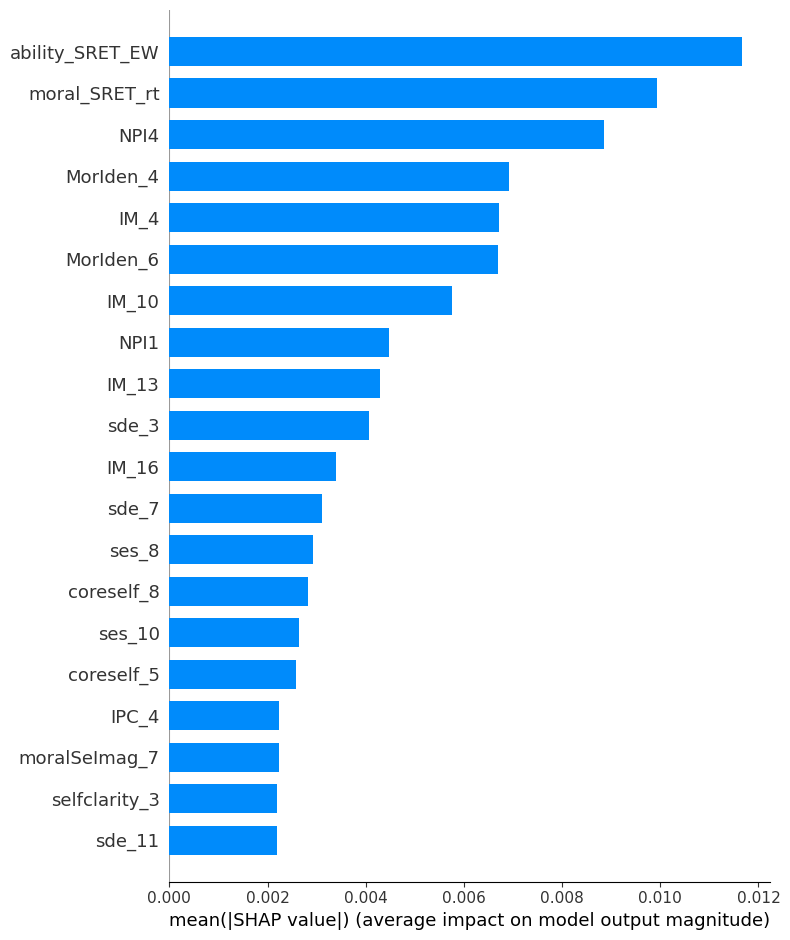

In [20]:
# 用 AutoGluon 训练好的模型预测 gad，并用 SHAP 检查模型到底依赖哪些特征，按重要性排名绘图
# 初始化 AutogluonWrapper
ag_wrapper = AutogluonWrapper(predictor, feature_names)

# 构建 SHAP KernelExplainer
explainer = shap.KernelExplainer(ag_wrapper.predict, X_train_summary)

# 让 SHAP 计算在测试集上的每个样本、每个特征的 贡献值（SHAP values）
shap_values = explainer.shap_values(X_test[feature_names])

# 绘制 SHAP 总结图（显示前20个重要的特征）
shap.summary_plot(shap_values, X_test[feature_names], plot_type="bar", max_display=20)

In [26]:
# 解释单个被试的预测结果，展示哪些问卷条目对被试的 gad 预测起了推动或抑制作用
ROW_INDEX = 0  # 从训练集 X_train 里取第 0 行数据，即第一个被试
single_datapoint = X_train.iloc[[ROW_INDEX]]
single_prediction = ag_wrapper.predict(single_datapoint)
# 每个特征对该样本预测的具体贡献：正 SHAP 值把预测往更高的 gad 推，负 SHAP 值把预测往更低的 gad 推
shap_values_single = explainer.shap_values(single_datapoint)
# 可视化
shap.force_plot(explainer.expected_value, shap_values_single, X_train.iloc[ROW_INDEX,:])

  0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
# 针对 X_train 里的 每一个样本被试，计算每个条目对预测 gad 的贡献。结果是一个矩阵：形状是 [行：样本数 × 列：特征数]，数值 = 贡献大小

# 计算训练集 SHAP
#shap_values = explainer.shap_values(X_train)
#shap.force_plot(explainer.expected_value, shap_values,X_train)

# 计算测试集 SHAP
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value, shap_values, X_test)

  0%|          | 0/101 [00:00<?, ?it/s]

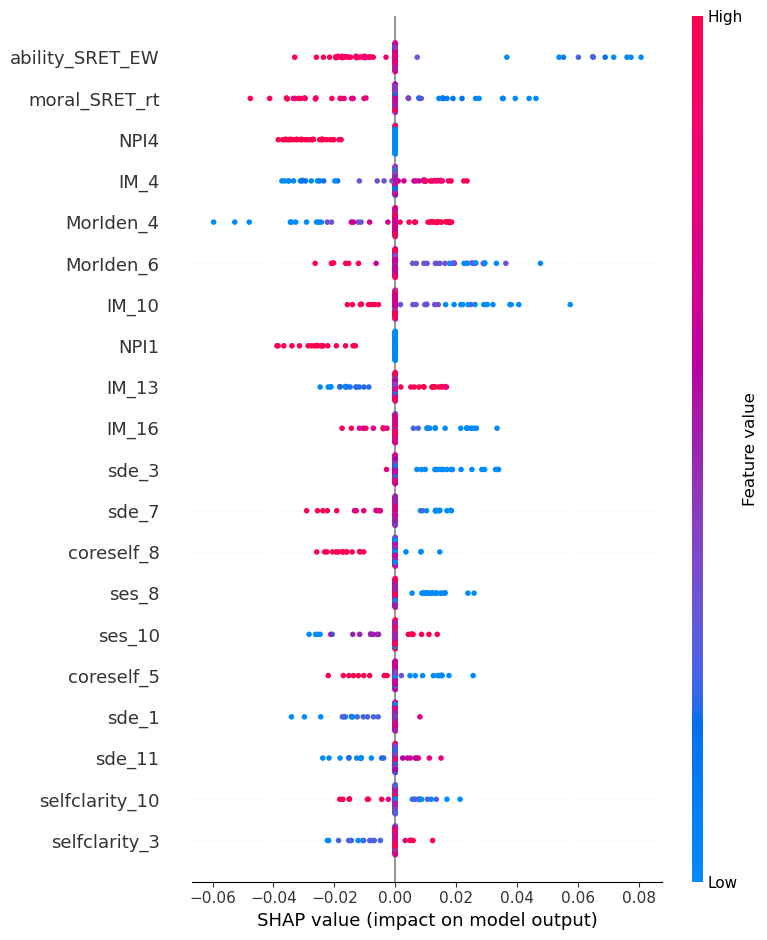

In [28]:
# 生成SHAP 总结图
# 训练集总结图
#shap.summary_plot(shap_values, X_train[feature_names])
# 测试集总结图
shap.summary_plot(shap_values, X_test[feature_names])

In [77]:
# 训练时 label 变量对应的问题类型
print("Problem type:", predictor.problem_type)

Problem type: regression


  0%|          | 0/101 [00:00<?, ?it/s]

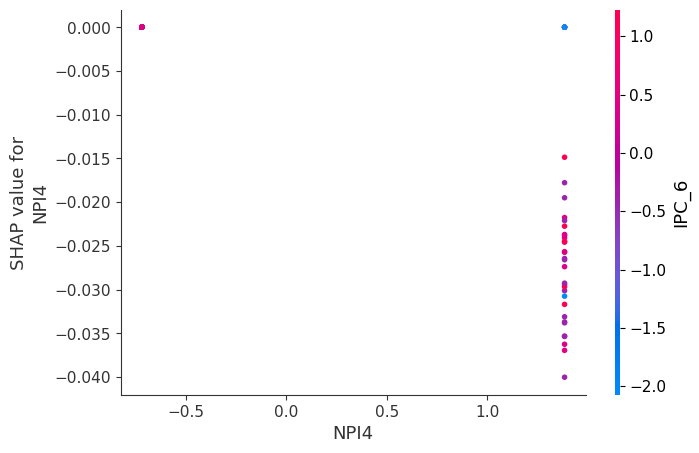

In [63]:
# 直观展示某个特征（比如 "NPI4"）对模型预测的影响
# 计算训练集 SHAP，绘制plot
#shap_values = explainer.shap_values(X_train[feature_names])
#shap.dependence_plot("NPI4", shap_values, X_train[feature_names])

# 计算测试集 SHAP，绘制plot
shap_values = explainer.shap_values(X_test[feature_names])
shap.dependence_plot("NPI4", shap_values, X_test[feature_names])

# 3. Exploratory Factor Analysis (EFA)

In this section, we will perform Exploratory Factor Analysis (EFA) to uncover the underlying factor structure in the data. EFA helps in identifying the latent variables that explain the patterns in the observed variables.

## 3.1 Preparing Data for EFA

To perform Exploratory Factor Analysis (EFA), we need to calculate the importance of variables and exclude those that do not meet a certain threshold. In this case, we will include variables that contribute up to 80% of the total importance and exclude demographic variables.

In [22]:
# Calculate cumulative importance
# 计算并整理特征的重要性排名，同时加上累计贡献度
shap_values_train = np.array(shap_values)  
feature_importance = np.mean(np.abs(shap_values_train), axis=0)
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)
feature_importance_df['cumulative_importance'] = feature_importance_df['importance'].cumsum()
feature_importance_df['cumulative_importance'] /= feature_importance_df['importance'].sum()

In [23]:
# Determine the number of features to reach 80% importance
# 利用累计贡献率 80% 来确定保留多少因子
threshold = 0.8
num_important_features = (feature_importance_df['cumulative_importance'] <= threshold).sum()
print(f"Number of features to reach {threshold*100}% of importance: {num_important_features}")

Number of features to reach 80.0% of importance: 34


In [24]:
# Printing the Names and Importance of the Top 24 Features
# 从高到低依次打印累计80%贡献率的特征变量名称
top_features = feature_importance_df.head(num_important_features)
important_feature_names = top_features['feature'].tolist()
print(top_features[['feature', 'importance']])

             feature  importance
136  ability_SRET_EW    0.011658
139    moral_SRET_rt    0.009942
49              NPI4    0.008847
72         MorIden_4    0.006917
111             IM_4    0.006710
74         MorIden_6    0.006699
117            IM_10    0.005762
46              NPI1    0.004473
120            IM_13    0.004282
90             sde_3    0.004065
123            IM_16    0.003400
94             sde_7    0.003117
33             ses_8    0.002936
43        coreself_8    0.002823
35            ses_10    0.002639
40        coreself_5    0.002577
21             IPC_4    0.002241
85     moralSeImag_7    0.002235
2      selfclarity_3    0.002200
98            sde_11    0.002188
82     moralSeImag_4    0.002170
9     selfclarity_10    0.002102
102           sde_15    0.002087
88             sde_1    0.002085
42        coreself_7    0.001909
56             NPI11    0.001792
134     moral_ALT_rt    0.001716
95             sde_8    0.001465
119            IM_12    0.001458
34        

# Printing the Names and Importance of the Top Features
top_features = feature_importance_df.head(num_important_features)
important_feature_names = top_features['feature'].tolist()
print(top_features[['feature', 'importance']])

In [25]:
# Exclude demographic variables
# 去掉不想要的变量，只保留剩下的重要特征数据
#variables_to_remove = ['Gender_1.0', 'Gender_2.0','Daily online duration']
#important_feature_names = [feature for feature in important_feature_names if feature not in variables_to_remove]
important_data = data_gad[important_feature_names]

## 3.2 Parallel Analysis to Determine the Number of Factors

To determine the appropriate number of factors for Exploratory Factor Analysis (EFA), we perform parallel analysis. This method compares the eigenvalues from the actual data with those from randomly generated data.

**Bartlett's Test of Sphericity:** This test assesses whether the correlation matrix is an identity matrix, which would indicate that variables are unrelated. A significant result (p-value < 0.05) suggests that the correlation matrix is not an identity matrix, implying that the data is suitable for factor analysis.

**KMO Test:** The KMO test evaluates the adequacy of the correlation matrix for factor analysis. It measures the proportion of variance among variables that might be common variance. The KMO statistic ranges from 0 to 1, with values closer to 1 indicating that the data is suitable for factor analysis.


In [26]:
# 计算 RMSEA（Root Mean Square Error of Approximation）
def calculate_rmsea(chi_square, dof, n):
    rmsea = np.sqrt((chi_square - dof) / (dof * (n - 1)))
    return rmsea

# 计算 TLI（Tucker–Lewis Index）：拟合优度指标，越接近 1 表示模型拟合越好
def calculate_tli(chi_square, dof, chi_square_null, dof_null):
    tli = 1 - (chi_square / dof) / (chi_square_null / dof_null)
    return tli

# Bartlett 球形检验：如果 p < 0.05 → 可以拒绝零假设 → 数据适合因子分析
# Bartlett's Test of Sphericity
# To ensure that the variables are sufficiently correlated for factor analysis, we perform Bartlett's Test of Sphericity. This test checks whether the correlation matrix is significantly different from an identity matrix.
bartlett_test, p_value = calculate_bartlett_sphericity(important_data)
print(f"Bartlett's Test: Chi-square = {bartlett_test}, p-value = {p_value}")

# KMO (Kaiser-Meyer-Olkin) 检验：衡量因子分析的适用性：0.9 = 极好；0.8 = 良好；0.7 = 可以接受；< 0.6 = 不适合做因子分析
# Perform the Kaiser-Meyer-Olkin (KMO) Test
kmo_all, kmo_model = calculate_kmo(important_data)
print(f"KMO Test: {kmo_model}")

Bartlett's Test: Chi-square = 6918.92593390921, p-value = 0.0
KMO Test: 0.9028260920271528


**Parallel Analysis (Simplified Implementation)**

Determines optimal number of factors by comparing eigenvalues from actual data with those derived from random data using PCA, calculating mean random eigenvalues (mean_random_eigenvalues) as a threshold for component retention

In [27]:
# 定义 parallel_analysis 函数，n_iterations: 随机数据重复生成的次数（默认 1000 次）
def parallel_analysis(data_gad, n_iterations=1000):
    n_samples, n_features = data_gad.shape
    random_eigenvalues = np.zeros((n_iterations, n_features))
    for i in range(n_iterations):
        random_data = np.random.normal(size=data_gad.shape)
        pca = PCA()
        pca.fit(random_data)
        random_eigenvalues[i, :] = pca.explained_variance_
    mean_random_eigenvalues = random_eigenvalues.mean(axis=0)
    return mean_random_eigenvalues

# important_data是经过特征选择后保留下来的关键变量子集（80%）
pca = PCA()
pca.fit(important_data)
eigenvalues = pca.explained_variance_
mean_random_eigenvalues = parallel_analysis(important_data)
num_factors = np.sum(eigenvalues > mean_random_eigenvalues)
print(f"Number of factors to retain based on parallel analysis: {num_factors}")

Number of factors to retain based on parallel analysis: 5


In [29]:
# 基于前面平行分析得出的因子个数（num_factors），对 important_data 做因子分析（EFA）
# Create the FactorAnalyzer object, specifying the number of factors to retain
fa = FactorAnalyzer(n_factors=num_factors, rotation='varimax')
fa.fit(important_data)

FactorAnalyzer(n_factors=5, rotation='varimax', rotation_kwargs={})

In [30]:
# Get the factor loadings
#  提取并整理因子载荷矩阵
loadings = fa.loadings_
variable_names = important_data.columns.tolist()
num_factors = loadings.shape[1]
factor_names = [f'Factor{i+1}' for i in range(num_factors)]
factor_loadings_df = pd.DataFrame(loadings, index=variable_names,columns=factor_names)

# Remove loadings with absolute values less than 0.3
# 过滤掉小于 0.3 的载荷
factor_loadings_df = factor_loadings_df.where(abs(factor_loadings_df) >= 0.3, '')
print("Factor Loadings: \n", factor_loadings_df)

Factor Loadings: 
                   Factor1   Factor2   Factor3   Factor4   Factor5
ability_SRET_EW                      0.478266                    
moral_SRET_rt                                                    
NPI4                                           0.702519          
MorIden_4                                                        
IM_4                       0.747317                              
MorIden_6                  0.499587                              
IM_10                                                            
NPI1                                           0.492902          
IM_13                                                            
sde_3              0.3029  0.441396                              
IM_16                      0.557523                              
sde_7                       0.44288                              
ses_8            0.517178                                        
coreself_8       0.675166            0.373753            

In [31]:
# 假设你的 DataFrame 变量名是 factor_loadings
factor_loadings_df.to_csv("gad_factor_loadings.csv", index=False)

In [39]:
# 因子分析模型拟合优度（model fit evaluation），检验提取的因子模型在统计上是否合理
#Evaluation of the Factor Analysis Model
# Sample and variable counts
n = important_data.shape[0]
p = important_data.shape[1]

# Calculate correlation matrix 计算变量之间的相关矩阵
corr_matrix = np.corrcoef(important_data, rowvar=False)

# Get loadings and uniquenesses 获取因子载荷和残差方差
loadings = fa.loadings_
uniquenesses = 1 - np.sum(loadings**2, axis=1)

# Calculate model-implied correlation matrix 根据因子模型重建出来的相关矩阵。如果模型拟合得好，这个矩阵 ≈ 真实相关矩阵
model_corr = loadings @ loadings.T
np.fill_diagonal(model_corr, model_corr.diagonal() + uniquenesses)

# Calculate chi-square using maximum likelihood method 计算卡方检验 (χ²)。比较真实相关矩阵 vs 模型相关矩阵的差异。差异越小，模型越好
log_det_corr = np.log(np.linalg.det(corr_matrix))
log_det_model = np.log(np.linalg.det(model_corr))
trace = np.trace(corr_matrix @ np.linalg.inv(model_corr)) - p
chi_square = (n - 1) * (log_det_model + trace - log_det_corr)

# Calculate degrees of freedom 基于观测参数和估计参数数量来计算自由度
dof = (p * (p + 1)) / 2 - (p * num_factors + p - (num_factors * (num_factors - 1)) / 2)

# Calculate null model chi-square 零模型假设：所有变量互相独立（仅保留真实数据相关矩阵的对角线部分）
# 引入零模型作为对照基线：因子模型的χ²显著下降、TLI≥0.90、RMSEA ≤ 0.08，那么可以说因子模型相比零模型有了明显改进
diag_corr = np.diag(np.diag(corr_matrix))
log_det_diag = np.log(np.linalg.det(diag_corr))
trace_null = np.trace(corr_matrix @ np.linalg.inv(diag_corr)) - p
chi_square_null = (n - 1) * (log_det_diag + trace_null - log_det_corr)
dof_null = p * (p - 1) / 2

# Calculate RMSEA 
rmsea = np.sqrt(max(0, (chi_square - dof) / (dof * (n - 1))))

# Calculate TLI
tli = ((chi_square_null / dof_null) - (chi_square / dof)) / ((chi_square_null / dof_null) - 1)

# 打印指标
print(f"RMSEA: {rmsea:.4f}")
print(f"TLI: {tli:.4f}")
print(f"Chi-square: {chi_square:.4f}, df: {dof:.4f}")
print(f"p-value: {1 - stats.chi2.cdf(chi_square, dof):.4f}")

RMSEA: 0.0583
TLI: 0.8626
Chi-square: 1009.3796, df: 373.0000
p-value: 0.0000


# # Extra Method 1: R and Python Interaction for Factor Analysis (Recommended)

The code utilizes the rpy2 interface to access R's psych package, preserving R's professional advantages in psychological statistical analysis while incorporating Python's flexibility and data processing capabilities. Users only need to provide appropriately formatted data files, and the system automatically handles R environment configuration, necessary package installation, data conversion, statistical analysis, and results presentation.

The framework supports multiple factor extraction methods and rotation techniques, while providing comprehensive model fit indicators such as RMSEA, TLI, and BIC. This integration delivers a powerful yet user-friendly solution for researchers and practitioners working with psychometric data, combining the best statistical tools from both programming ecosystems.



In [78]:
# Save the Data to CSV File
important_data.to_csv("factor_analysis_data_r.csv", index=False)
print("Factor analysis data successfully exported to factor_analysis_data.csv")

Factor analysis data successfully exported to factor_analysis_data.csv


In [87]:
# Set up R environment
import os
os.environ['R_HOME'] = r'/Library/Frameworks/R.framework/Versions/4.4.1/Resources'  # Use your correct R installation path
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.conversion import localconverter

# Activate pandas to R data conversion
#pandas2ri.activate()
import rpy2.robjects.pandas2ri as pandas2ri
# 读取数据
df = pd.read_csv("/Users/sunxinru/Desktop/ML/Data/ML_pre.csv")

# 在 with 语句里完成 DataFrame -> R data.frame 的转换
#with localconverter(ro.default_converter + pandas2ri.converter):
    #r_df = ro.conversion.py2rpy(df)

def run_parallel_analysis(data_path, fa_method="both", n_iter=100, fm="ml"):
    """
    Run parallel analysis on the data with the specified method.
    
    Parameters:
    -----------
    data_path : str
        Path to the CSV file containing the data.
    fa_method : str
        Method for parallel analysis. Options: "pc", "fa", or "both".
    n_iter : int
        Number of iterations for simulation.
    fm : str
        Factor extraction method. Options: "ml", "minres", "pa", etc.
        
    Returns:
    --------
    dict
        A dictionary containing the analysis results.
    """
    try:
        # Import R base packages
        base = importr('base')
        utils = importr('utils')
        psych = importr('psych')
        
        # Read data
        df = pd.read_csv(data_path)
        print(f"Data successfully loaded: {df.shape[0]} rows and {df.shape[1]} columns")
        
        # Convert data to R dataframe
        with localconverter(ro.default_converter + pandas2ri.converter):
            r_df = ro.conversion.py2rpy(df)
        
        # Execute parallel analysis
        print(f"Starting parallel analysis with method: {fa_method}...")
        ro.r('set.seed(123)')

        r_setup = """
        pdf(file=NULL) 
        """
        ro.r(r_setup)

        # Use R string to execute parallel analysis
        r_code = f"""
        parallel_result <- function(df) {{
          library(psych)
          result <- fa.parallel(df, fa="{fa_method}", fm="{fm}", n.iter={n_iter}, sim=TRUE, show=FALSE)
          dev.off()  
          return(result)
        }}
        """
        ro.r(r_code)
        parallel_result = ro.r('parallel_result')(r_df)
        
        # Extract results based on analysis method
        result = {}
        
        if fa_method in ["fa", "both"]:
            n_factors = parallel_result.rx2('nfact')[0]
            result["n_factors"] = n_factors
            print(f"Suggested number of factors: {n_factors}")
        
        if fa_method in ["pc", "both"]:
            n_components = parallel_result.rx2('ncomp')[0]
            result["n_components"] = n_components
            print(f"Suggested number of components: {n_components}")
        
        # Extract relevant eigenvalues based on method
        r_extract_values = f"""
        extract_values <- function(result) {{
          list(
            observed = if("{fa_method}" == "pc") result$pc.values else if("{fa_method}" == "fa") result$fa.values else NULL,
            simulated = if("{fa_method}" == "pc") {{
              if(is.matrix(result$pc.sim)) colMeans(result$pc.sim) else result$pc.simr
            }} else if("{fa_method}" == "fa") {{
              if(is.matrix(result$fa.sim)) colMeans(result$fa.sim) else result$fa.simr
            }} else NULL,
            fa_observed = if("{fa_method}" == "both") result$fa.values else NULL,
            fa_simulated = if("{fa_method}" == "both") {{
              if(is.matrix(result$fa.sim)) colMeans(result$fa.sim) else result$fa.simr
            }} else NULL,
            pc_observed = if("{fa_method}" == "both") result$pc.values else NULL,
            pc_simulated = if("{fa_method}" == "both") {{
              if(is.matrix(result$pc.sim)) colMeans(result$pc.sim) else result$pc.simr
            }} else NULL
          )
        }}
        """
        ro.r(r_extract_values)
        extracted_values = ro.r('extract_values')(parallel_result)
        
        # Convert R values to Python
        with localconverter(ro.default_converter + pandas2ri.converter):
            if fa_method in ["pc", "fa"]:
                observed = ro.conversion.rpy2py(extracted_values.rx2('observed'))
                simulated = ro.conversion.rpy2py(extracted_values.rx2('simulated'))
                result["observed"] = observed
                result["simulated"] = simulated
            elif fa_method == "both":
                fa_observed = ro.conversion.rpy2py(extracted_values.rx2('fa_observed'))
                fa_simulated = ro.conversion.rpy2py(extracted_values.rx2('fa_simulated'))
                pc_observed = ro.conversion.rpy2py(extracted_values.rx2('pc_observed'))
                pc_simulated = ro.conversion.rpy2py(extracted_values.rx2('pc_simulated'))
                result["fa_observed"] = fa_observed
                result["fa_simulated"] = fa_simulated
                result["pc_observed"] = pc_observed
                result["pc_simulated"] = pc_simulated
        
        # Save suggested factor numbers to file
        #with open(f'suggested_factors_{fa_method}.txt', 'w') as f:
        #    if fa_method in ["fa", "both"]:
        #        f.write(f"Suggested number of factors: {n_factors}\n")
        #    if fa_method in ["pc", "both"]:
        #        f.write(f"Suggested number of components: {n_components}")
        
       # print(f"Parallel analysis completed with method '{fa_method}' and results saved to text file.")
        
        return result
    
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Example usage
if __name__ == "__main__":
    # Change this to the desired method: "pc", "fa", or "both"
    analysis_method = "both"
    
    # Run the analysis
    result = run_parallel_analysis("factor_analysis_data_r.csv", 
                                  fa_method=analysis_method,
                                  n_iter=100, 
                                  fm="pa")

ImportError: cannot import name 'pandas2ri' from 'rpy2.robjects' (unknown location)

In [46]:
try:
    # Import R base packages
    base = importr('base')
    utils = importr('utils')
    stats = importr('stats')
    
    # Check and install necessary R packages
    package_names = ['psych', 'lavaan']
    utils.chooseCRANmirror(ind=1)  # Select CRAN mirror
    
    # Check if packages are installed, install if not
    names_to_install = [x for x in package_names if not ro.packages.isinstalled(x)]
    if len(names_to_install) > 0:
        print(f"Installing R packages: {', '.join(names_to_install)}")
        utils.install_packages(StrVector(names_to_install))
    
    # Import required R packages
    psych = importr('psych')
    lavaan = importr('lavaan')
    
    # Read data
    # Assuming your data is stored in a CSV file
    try:
        data_path = "factor_analysis_data.csv"  # Ensure this file exists
        df = pd.read_csv(data_path)
        print(f"Data successfully loaded: {df.shape[0]} rows and {df.shape[1]} columns")
        
        # Convert pandas dataframe to R dataframe
        with localconverter(ro.default_converter + pandas2ri.converter):
            r_df = ro.conversion.py2rpy(df)
        
        # Execute factor analysis
        print("Starting factor analysis...")
        fa_result = psych.fa(r_df, nfactors=5, rotate="varimax")
        
        # Extract results
        # Get fit indices
        rmsea = fa_result.rx2('RMSEA')[0]
        tli = fa_result.rx2('TLI')[0] if 'TLI' in fa_result.names else None
        bic = fa_result.rx2('BIC')[0] if 'BIC' in fa_result.names else None
        chi_square = fa_result.rx2('chi')[0] if 'chi' in fa_result.names else None
        df_value = fa_result.rx2('dof')[0] if 'dof' in fa_result.names else None
        p_value = fa_result.rx2('PVAL')[0] if 'PVAL' in fa_result.names else None
        
        # Create fit indices dataframe
        fit_indices = pd.DataFrame({
            'RMSEA': [rmsea],
            'TLI': [tli],
            'BIC': [bic],
            'chi_square': [chi_square],
            'df': [df_value],
            'p_value': [p_value]
        })
        
        # Get factor loadings
        loadings_r = fa_result.rx2('loadings')
        
        # Convert R matrix to pandas dataframe
        with localconverter(ro.default_converter + pandas2ri.converter):
            loadings_matrix = ro.conversion.rpy2py(loadings_r)
        
        # Create pandas dataframe from R matrix
        column_names = [f"Factor{i+1}" for i in range(loadings_matrix.shape[1])]
        loadings_df = pd.DataFrame(
            loadings_matrix, 
            index=df.columns, 
            columns=column_names
        )
        
        # Save results to CSV files (if needed)
        #fit_indices.to_csv("fit_indices.csv", index=False)
        #loadings_df.to_csv("factor_loadings.csv")
        
        # Display results
        print("\nFit indices:")
        print(fit_indices)
        print("\nFactor loadings:")
        print(loadings_df)
        
    except FileNotFoundError:
        print(f"Error: Data file '{data_path}' not found, please check the file path")
    except Exception as e:
        print(f"Error processing data: {str(e)}")

except ImportError as e:
    print(f"R package import error: {str(e)}")
    print("Please ensure R and required R packages are correctly installed")
except Exception as e:
    print(f"An error occurred: {str(e)}")

R callback write-console: Warning:  
R callback write-console:  failed to download mirrors file (internet routines cannot be loaded); using local file '/Library/Frameworks/R.framework/Resources/doc/CRAN_mirrors.csv'
  


Error: Data file 'factor_analysis_data.csv' not found, please check the file path


### Additional Method 2: Parallel Analysis Package

The parallel-analysis package offers a comprehensive implementation with enhanced functionality.
However, this Python package is published on the test channel. It is recommended to use Additional Method 1 for more refined control.

Based on package: https://test.pypi.org/project/parallel-analysis/

In [56]:
from parallel_analysis import parallel_analysis

# Perform parallel analysis on the data (using both PCA and FA methods)
results = parallel_analysis(
    important_data,
    n_iterations=100,   # Set 100 iterations for more stable results
    percentile=95,      # Use the 95th percentile as the threshold
    random_state=123,   # Set random seed to ensure reproducibility
    fa="both",          # Use both PCA and FA methods for analysis
    fm="pa",            # Use principal axis factor extraction method
)

# Print PCA results
print("=== PCA Parallel Analysis Results ===")
print(f"Number of components suggested to retain: {results['pc']['n_components']}")

# Print FA results
if 'fa' in results:
    print("\n=== FA Parallel Analysis Results ===")
    print(f"Number of factors suggested to retain: {results['fa']['n_components']}")


=== PCA Parallel Analysis Results ===
Number of components suggested to retain: 2

=== FA Parallel Analysis Results ===
Number of factors suggested to retain: 3
